In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [3]:
ten_data = pd.read_csv('./descriptive_stats/tenure_dist.csv')

In [4]:
years_range = ten_data['yd'].unique()
ten_data.head()

,sexo1,edad5,yd,state,wife,husband,mother,mother_5,mother_10,mother_15,...,father_15,father_state,hub_state,hub_ten_y,tenure,ten_y,wife_state,wife_ten,disc,part_time
0,1,20,2005,T,0,0,0,0,0,0,...,0,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0
1,0,45,2005,P,0,1,0,0,0,0,...,0,NaN,P,29.916666,359,29.916666,P,48.0,0,0
2,1,45,2005,P,1,0,0,0,0,0,...,0,NaN,P,29.916666,48,4.000000,P,48.0,0,1
3,1,25,2005,T,0,0,0,0,0,0,...,0,NaN,P,29.916666,10,NaN,P,48.0,0,0
4,0,55,2005,P,0,0,0,0,0,0,...,0,NaN,NaN,NaN,387,NaN,NaN,NaN,0,0


In [100]:
path = './plots_hist/'
kid_age_range = np.array((5,10,15))
parent_age_range = np.array([30,35,40])
ten_range = np.arange(0,31,1)
years_sample = years_range[-6:]

T = ten_range.size
Y = years_sample.size

mux = pd.MultiIndex.from_product([parent_age_range, kid_age_range, years_sample,['women','men']])
MM = parent_age_range.size * kid_age_range.size * years_sample.size * 2

hist_dict, hist_dict_gross = np.zeros((T-1,MM)), np.zeros((T-1,MM))
# hist_dict, hist_dict_gross = pd.DataFrame(), pd.DataFrame()

ii = 0

for kid_age in kid_age_range:

    data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
    data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()

    for j,age in enumerate(parent_age_range):
        for i,year in enumerate(years_sample):
            dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                              np.logical_and(data_mothers['edad5']>=age,
                                                             data_mothers['edad5']<age+5)))]['ten_y'].copy()
            h, b = np.histogram(dta.values,bins=ten_range)
            hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h
            ii +=1
            
            dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                              np.logical_and(data_fathers['edad5']>=age,
                                                             data_fathers['edad5']<age+5)))]['ten_y'].copy()
            h, b = np.histogram(dta.values,bins=ten_range)
            hist_dict[:,ii],hist_dict_gross[:,ii] = h/np.sum(h), h
            ii+=1

hist_dict, hist_dict_gross = pd.DataFrame(hist_dict,columns=mux), pd.DataFrame(hist_dict_gross,columns=mux)

In [102]:
p_age = 30
k_age = 5

hist_diff_gross_m = np.zeros((T-1,Y-1))
hist_diff_gross_w = np.zeros((T-1,Y-1))
for i,year in enumerate(years_sample[1:]):
    hist_diff_gross_w[:,i] = hist_dict_gross[p_age][k_age][year]['women']-hist_dict_gross[30][5][year-1]['women']
    hist_diff_gross_m[:,i] = hist_dict_gross[p_age][k_age][year]['men']-hist_dict_gross[30][5][year-1]['men']

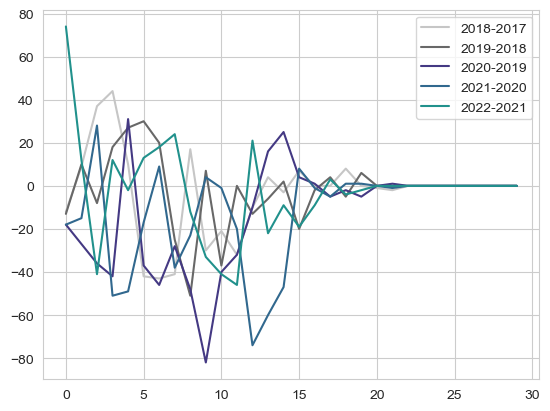

In [103]:
colors = sn.color_palette('Greys',2) + sn.color_palette('viridis',Y-1)
# sn.set_palette('viridis',Y-1)
for i,year in enumerate(years_sample[1:]):
    plt.plot(hist_diff_gross_w[:,i],label="{}-{}".format(year, year-1),c=colors[i])
plt.legend()
plt.show()

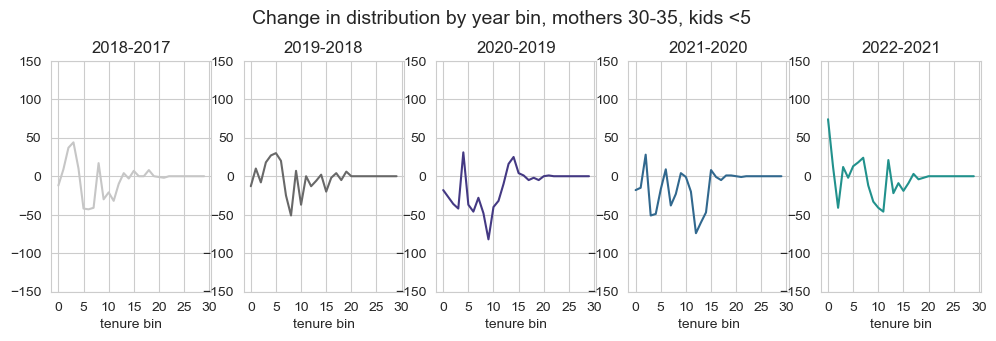

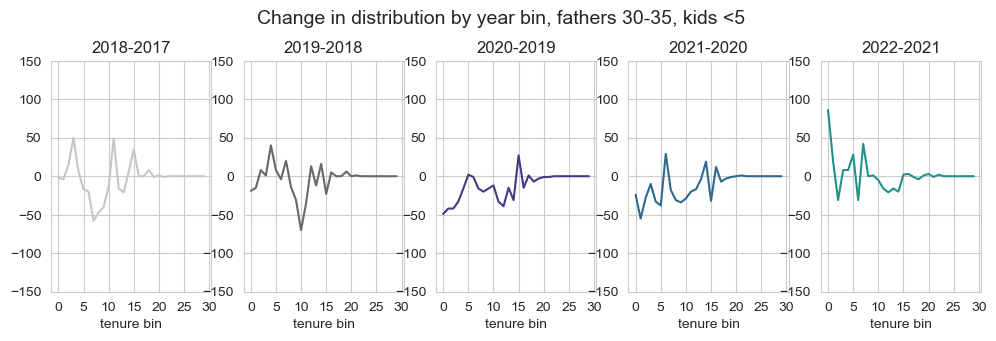

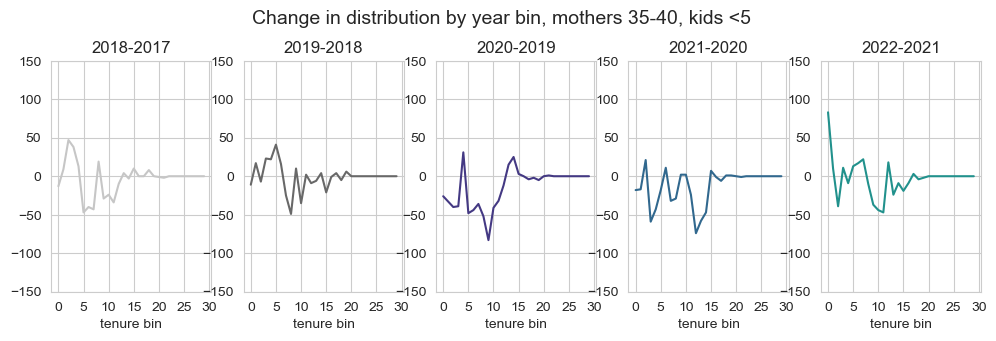

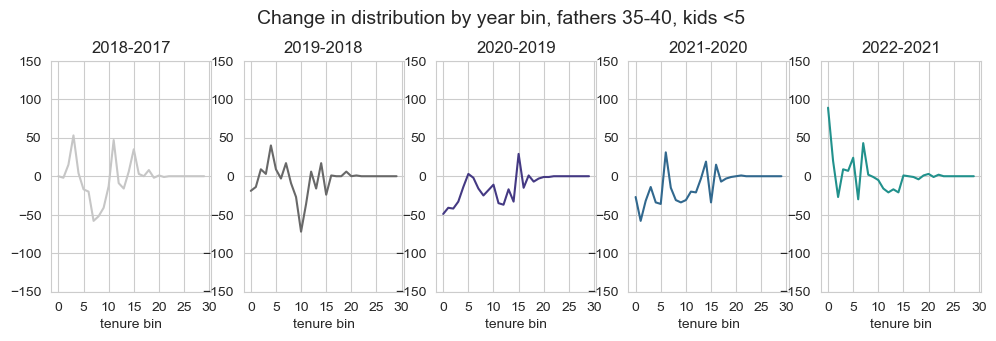

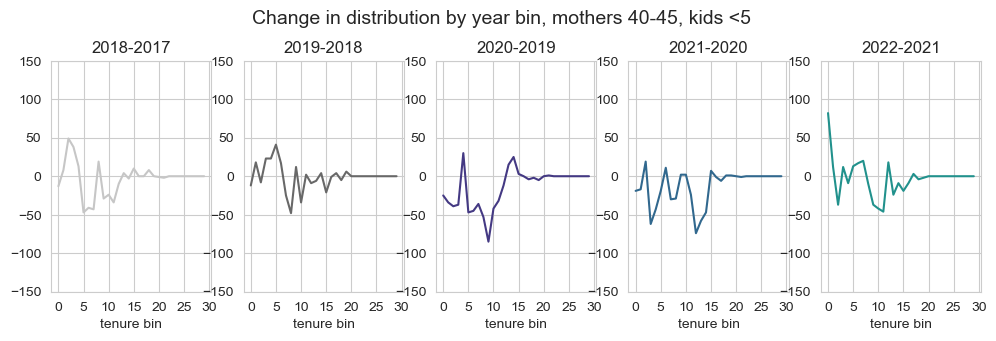

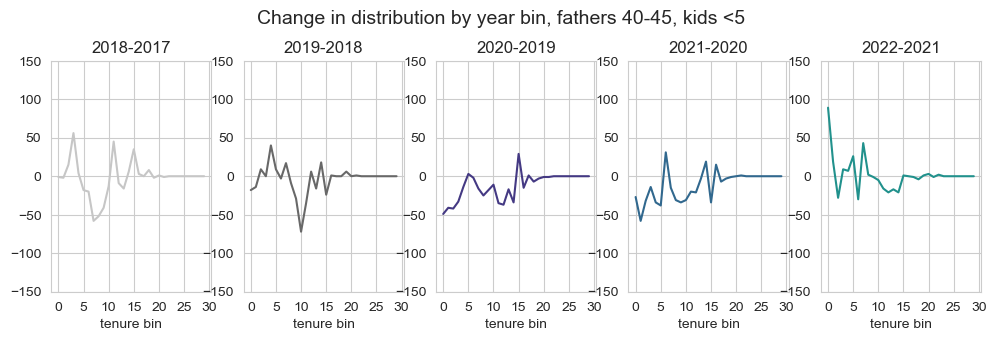

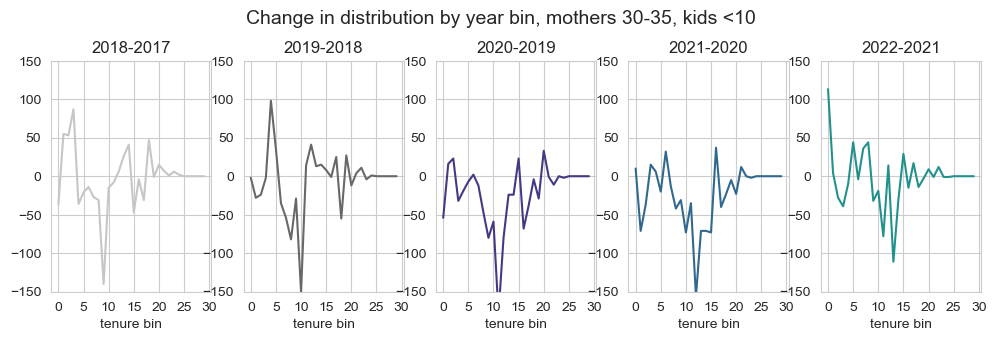

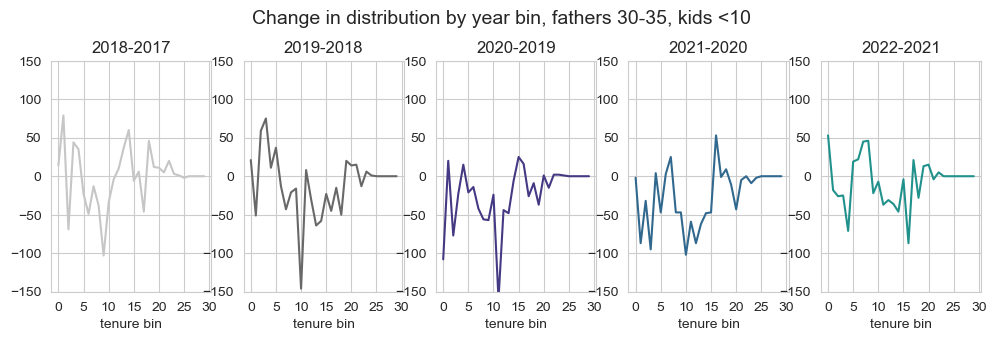

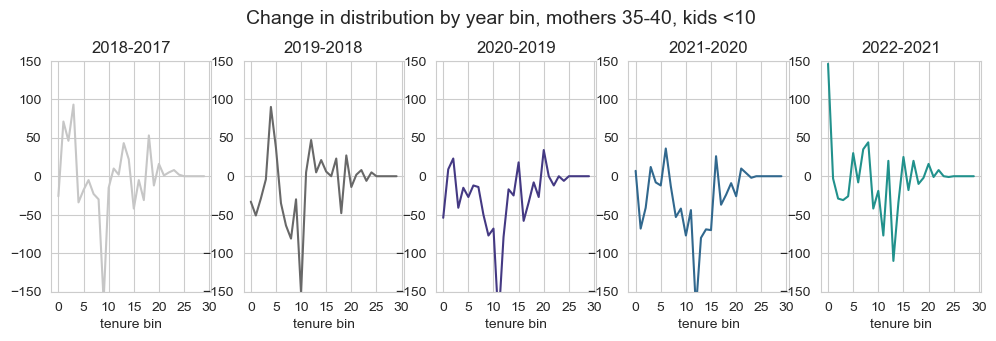

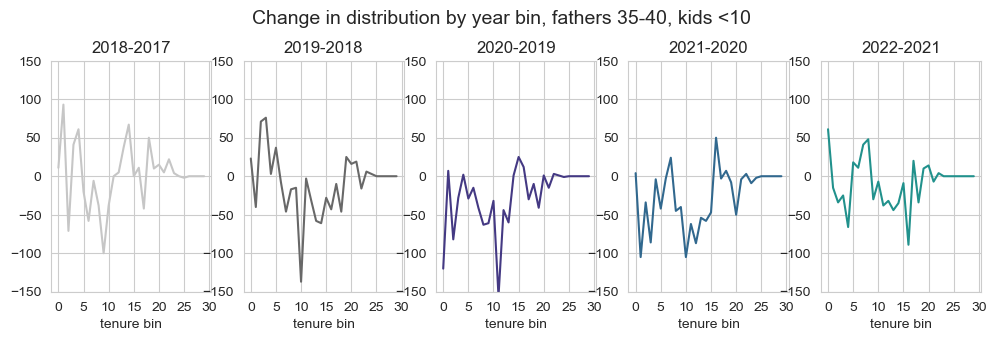

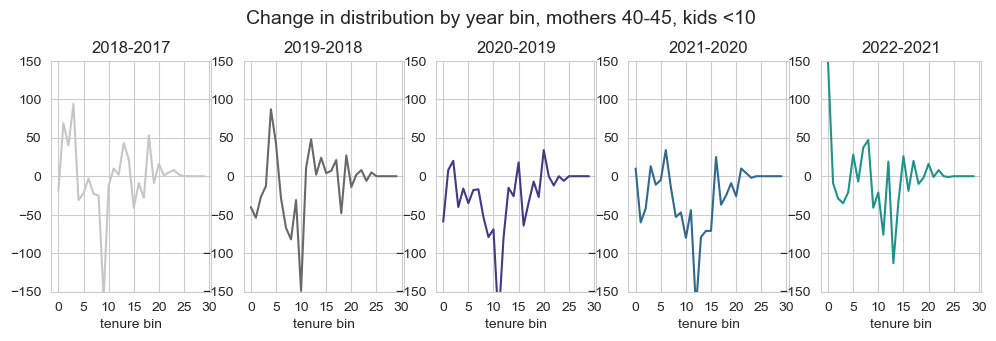

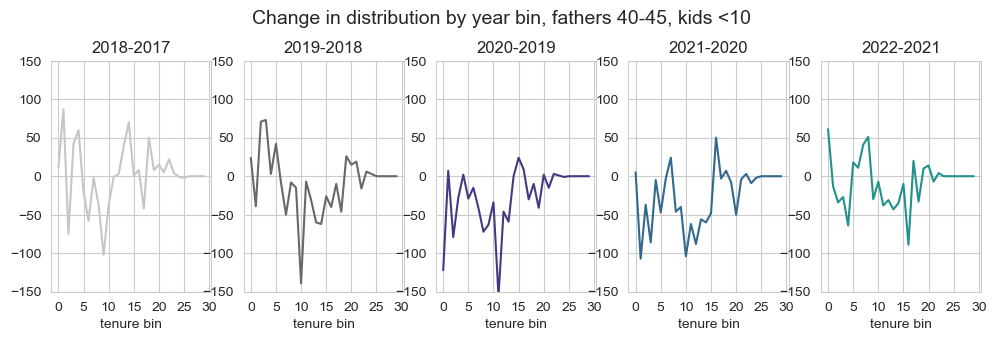

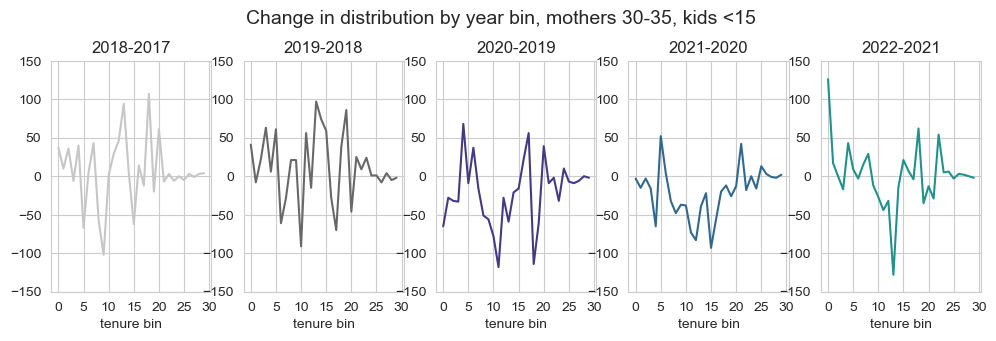

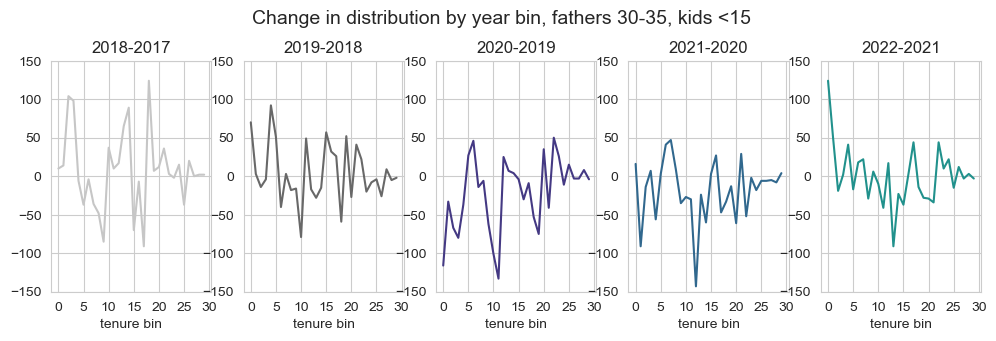

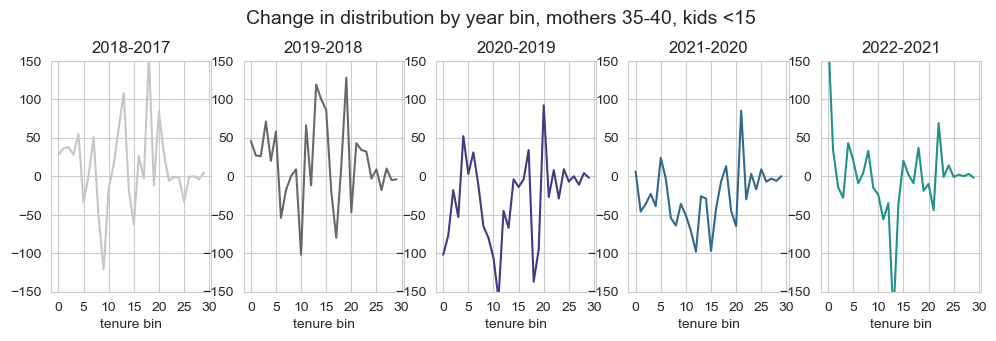

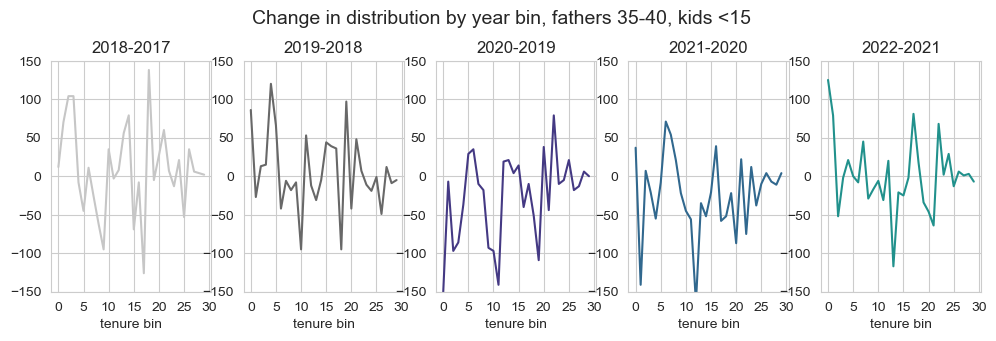

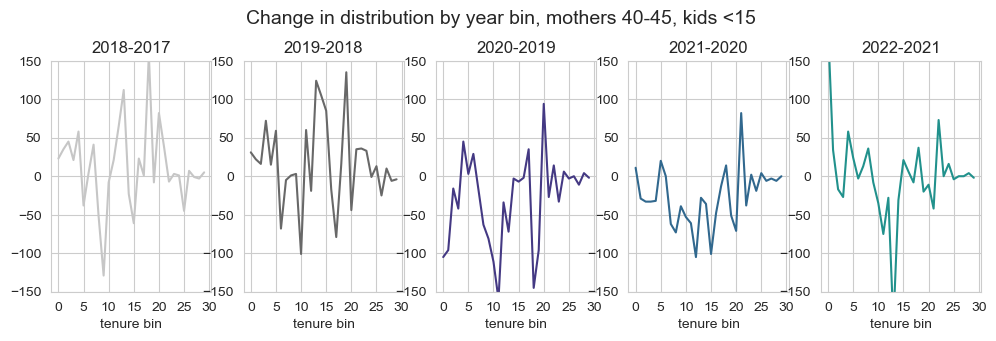

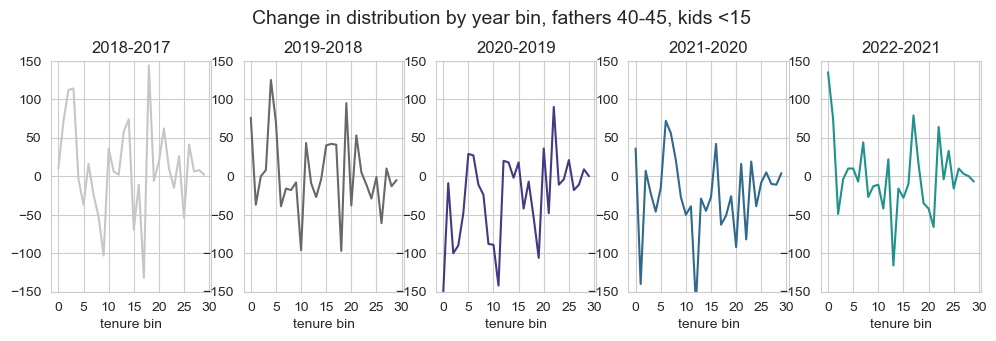

In [122]:
for k_age in kid_age_range:
    for p_age in parent_age_range:

        hist_diff_gross_m = np.zeros((T-1,Y-1))
        hist_diff_gross_w = np.zeros((T-1,Y-1))
        for i,year in enumerate(years_sample[1:]):
            hist_diff_gross_w[:,i] = hist_dict_gross[p_age][k_age][year]['women']-hist_dict_gross[p_age][k_age][year-1]['women']
            hist_diff_gross_m[:,i] = hist_dict_gross[p_age][k_age][year]['men']-hist_dict_gross[p_age][k_age][year-1]['men']

        plt.figure(figsize=(12,3))
        name = 'mothers {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Change in distribution by year bin, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample[1:]):
            plt.subplot(151+i)
            plt.title("{}-{}".format(year, year-1))
            plt.plot(hist_diff_gross_w[:,i],c=colors[i])
            plt.xticks(ten_range[::5])
            plt.xlabel('tenure bin')
            plt.ylim(-150,150)
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'.pdf',bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(12,3))
        name = 'fathers {}-{}, kids <{}'.format(p_age,p_age+5,k_age)
        plt.suptitle('Change in distribution by year bin, {}'.format(name),fontsize=14,y=1.05)
        for i,year in enumerate(years_sample[1:]):
            plt.subplot(151+i)
            plt.title("{}-{}".format(year, year-1))
            plt.plot(hist_diff_gross_m[:,i],c=colors[i])
            plt.xticks(ten_range[::5])
            plt.xlabel('tenure bin')
            plt.ylim(-150,150)
        plt.savefig(path+name.replace(" ","_").replace(",","").replace("<","")+'.pdf',bbox_inches='tight')
        plt.show()

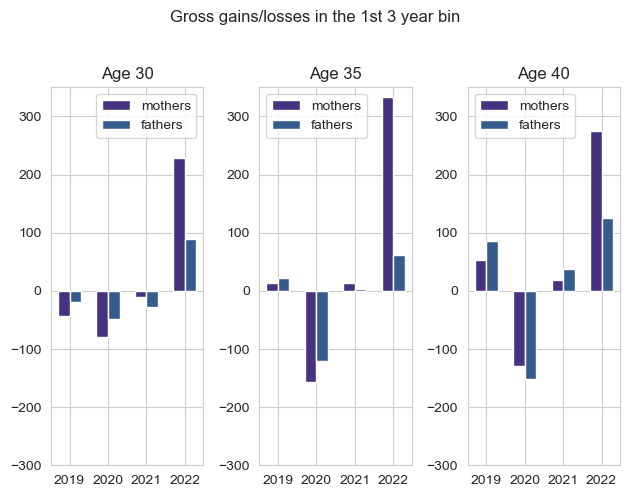

In [40]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_first_gross_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_first_gross_m[j,:], width=ww,label='fathers')
    plt.suptitle('Gross gains/losses in the 1st 3 year bin', y=1.025)
    plt.legend()
    plt.ylim(-300,350)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

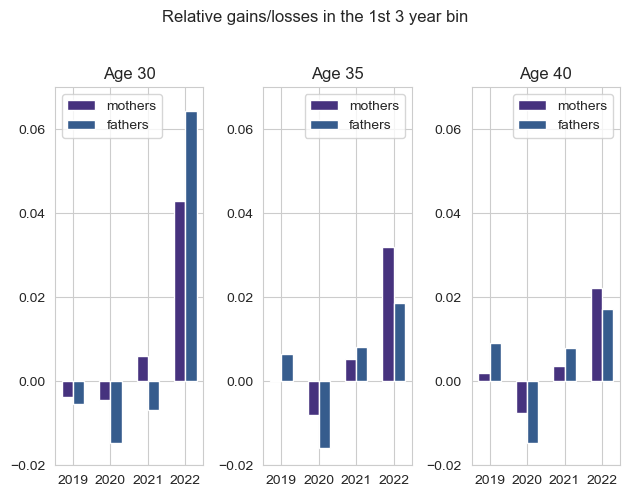

In [45]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_first_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_first_m[j,:], width=ww,label='fathers')
    plt.suptitle('Relative gains/losses in the 1st 3 year bin', y=1.025)
    plt.legend()
    plt.ylim(-0.02,0.07)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

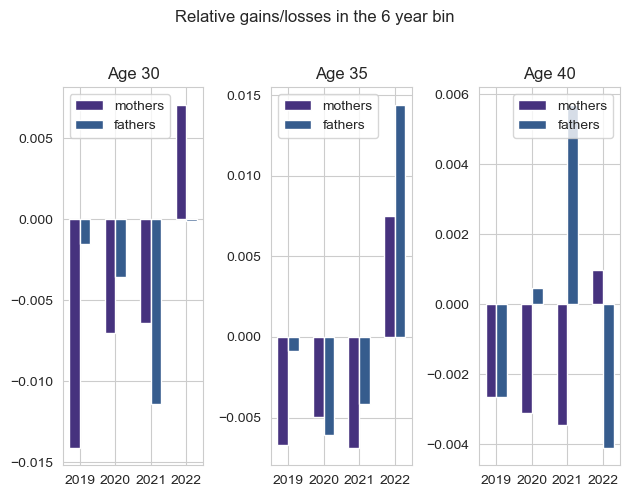

In [48]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_50_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_50_m[j,:], width=ww,label='fathers')
    plt.suptitle('Relative gains/losses in the 6 year bin', y=1.025)
    plt.legend()
#     plt.ylim(-0.04,0.06)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

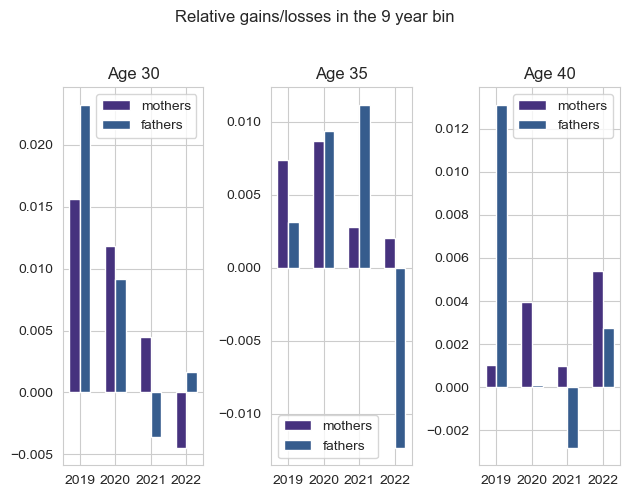

In [47]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_75_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_75_m[j,:], width=ww,label='fathers')
    plt.suptitle('Relative gains/losses in the 9 year bin', y=1.025)
    plt.legend()
#     plt.ylim(-0.04,0.06)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

In [166]:
diff_first_m[:,1:] - diff_first_m[:,:-1]


array([[ 0.00197691, -0.024091  , -0.0313093 ,  0.05280561],
       [ 0.01786827, -0.01058697, -0.00060916,  0.01379939],
       [ 0.00565145, -0.01801911, -0.00099028,  0.02055556]])

 - All lines in one plot, x-axis is tenure
 - Absolute numbers
 - 2019 base year for all